# <와인 데이터를 활용한 와인 추천 알고리즘 개발>

## 가설 설정
* 가설1 : 고객들은 반복구매를 할 때 유사한 종류의 와인을 구매할 것이다.
* 가설2 : 고객들은 간헐적으로 접해보지 못한 종류(군집)의 와인을 구매할 것이다.

---
## 데이터 준비

In [1]:
library(dplyr)


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [2]:
df <- read.csv('wine.data.csv')

colnames(df) <- c('Cultivar', 'Alcohol', 'Malic acid', 'Ash', 'Alcalinity of ash', 'Magesium',
                  'Total phenols', 'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                  'Proanthocyanins', 'Hue', 'OD280/OD315 of diluted wines', 'Proline')

In [3]:
str(df)

'data.frame':	177 obs. of  14 variables:
 $ Cultivar                    : int  1 1 1 1 1 1 1 1 1 1 ...
 $ Alcohol                     : num  13.2 13.2 14.4 13.2 14.2 ...
 $ Malic acid                  : num  1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 ...
 $ Ash                         : num  2.14 2.67 2.5 2.87 2.45 2.45 2.61 2.17 2.27 2.3 ...
 $ Alcalinity of ash           : num  11.2 18.6 16.8 21 15.2 14.6 17.6 14 16 18 ...
 $ Magesium                    : int  100 101 113 118 112 96 121 97 98 105 ...
 $ Total phenols               : num  2.65 2.8 3.85 2.8 3.27 2.5 2.6 2.8 2.98 2.95 ...
 $ Flavanoids                  : num  2.76 3.24 3.49 2.69 3.39 2.52 2.51 2.98 3.15 3.32 ...
 $ Nonflavanoid phenols        : num  0.26 0.3 0.24 0.39 0.34 0.3 0.31 0.29 0.22 0.22 ...
 $ Proanthocyanins             : num  1.28 2.81 2.18 1.82 1.97 1.98 1.25 1.98 1.85 2.38 ...
 $ Proanthocyanins             : num  4.38 5.68 7.8 4.32 6.75 5.25 5.05 5.2 7.22 5.75 ...
 $ Hue                         : n

클러스터링은 범주형 변수가 들어가면 안 되므로 Cultivar 변수 제외

In [4]:
# 결측치 확인
colSums(is.na(df))

Cultivar                      Alcohol 
                           0                            0 
                  Malic acid                          Ash 
                           0                            0 
           Alcalinity of ash                     Magesium 
                           0                            0 
               Total phenols                   Flavanoids 
                           0                            0 
        Nonflavanoid phenols              Proanthocyanins 
                           0                            0 
             Proanthocyanins                          Hue 
                           0                            0 
OD280/OD315 of diluted wines                      Proline 
                           0                            0

In [5]:
# 변수별 기술통계 및 분포 확인
summary(df[,-1])

    Alcohol        Malic acid        Ash        Alcalinity of ash
 Min.   :11.03   Min.   :0.74   Min.   :1.360   Min.   :10.60    
 1st Qu.:12.36   1st Qu.:1.60   1st Qu.:2.210   1st Qu.:17.20    
 Median :13.05   Median :1.87   Median :2.360   Median :19.50    
 Mean   :12.99   Mean   :2.34   Mean   :2.366   Mean   :19.52    
 3rd Qu.:13.67   3rd Qu.:3.10   3rd Qu.:2.560   3rd Qu.:21.50    
 Max.   :14.83   Max.   :5.80   Max.   :3.230   Max.   :30.00    
    Magesium      Total phenols     Flavanoids    Nonflavanoid phenols
 Min.   : 70.00   Min.   :0.980   Min.   :0.340   Min.   :0.1300      
 1st Qu.: 88.00   1st Qu.:1.740   1st Qu.:1.200   1st Qu.:0.2700      
 Median : 98.00   Median :2.350   Median :2.130   Median :0.3400      
 Mean   : 99.59   Mean   :2.292   Mean   :2.023   Mean   :0.3623      
 3rd Qu.:107.00   3rd Qu.:2.800   3rd Qu.:2.860   3rd Qu.:0.4400      
 Max.   :162.00   Max.   :3.880   Max.   :5.080   Max.   :0.6600      
 Proanthocyanins Proanthocyanins.1      H

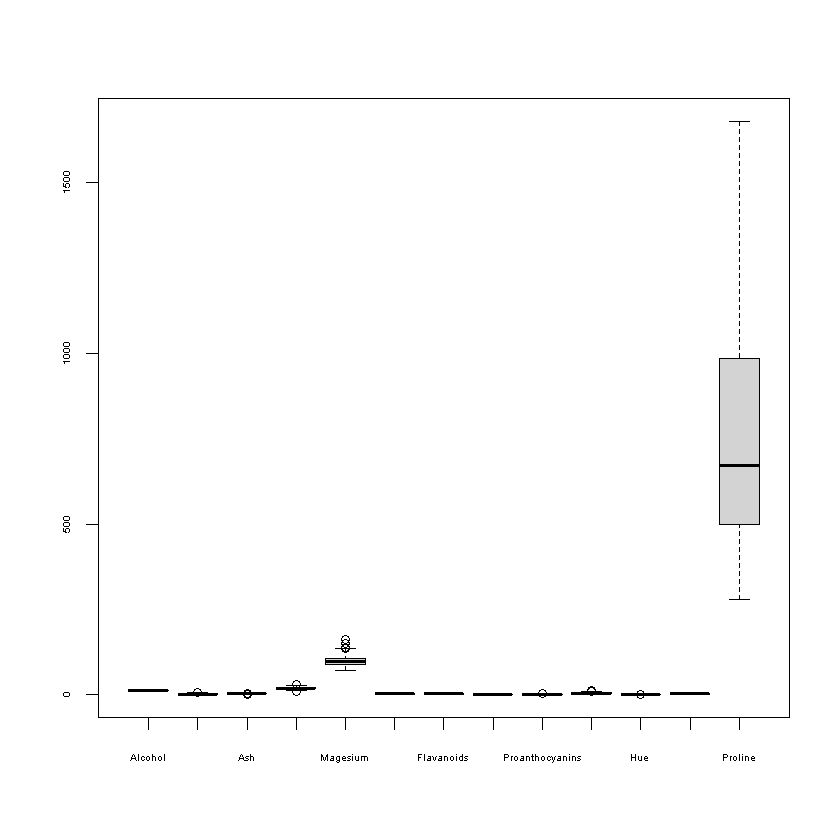

In [6]:
boxplot(df[,-1], cex.axis = 0.5) # ces.axis는 글자크기 설정 매개변수

null device 
          1

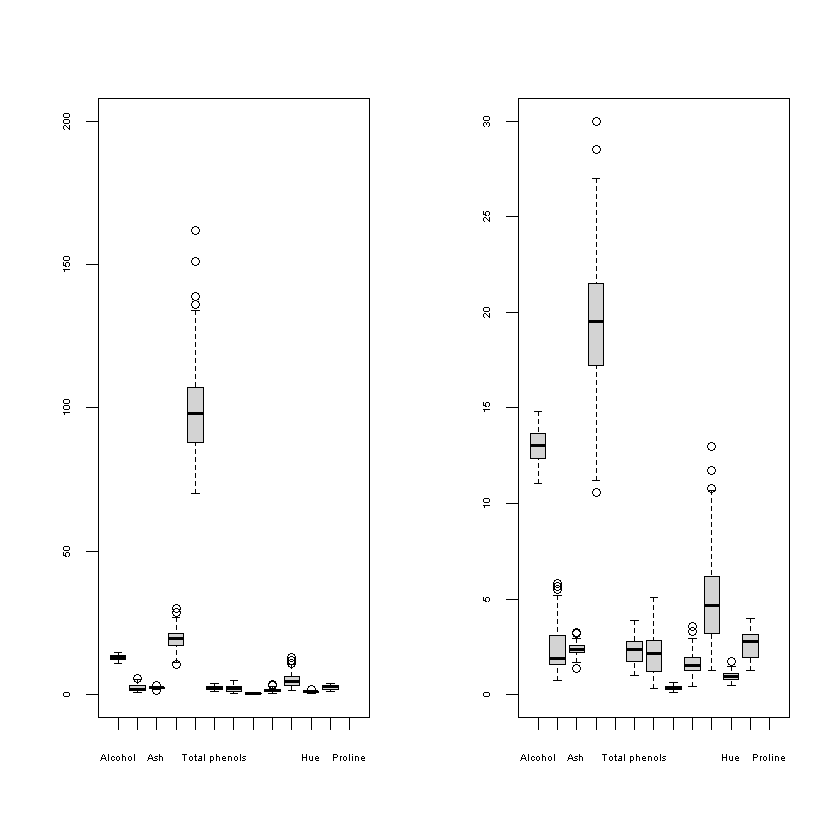

In [7]:
par(mfrow=(c(1, 2)))
boxplot(df[,-1], ylim = c(0, 200), cex.axis = 0.5)
boxplot(df[,-1], ylim = c(0, 30), cex.axis = 0.5)
dev.off()

In [8]:
# 표준화
df.train <- df[,-1] #cultivar (품종) 데이터 제외
df.train.scale <- scale(df.train)

## 분석(가설검정)
* 가설1 : 고객들은 반복구매를 할 때 유사한 종류의 와인을 구매할 것이다.
* 가설2 : 고객들은 간헐적으로 접해보지 못한 종류(군집)의 와인을 구매할 것이다.
    * 와인들 간의 유사도(거리) 계산
    * 군집분석을 통해 유사한 종류/다른 종류로 와인 분류
        * Euclidian Distance
        * K means
        * K medoids
        * Hierarchical Clustering
    * 분류된 와인을 선택하여 각 상품칸에 적절하게 배치
    * 고객들의 반응 확인

#### Euclidian Distance

In [9]:
df.dist <- dist(df.train.scale, method = "euclidean") %>% as.matrix()
df.dist

,1,2,3,4,5,6,7,8,9,10,...,168,169,170,171,172,173,174,175,176,177
1,0.000000,4.132370,4.349529,4.615292,3.385537,2.661000,3.320062,2.693016,2.494643,3.697511,...,6.332398,6.903032,5.668027,6.419999,5.958556,6.693439,6.096992,6.383195,6.083167,7.349167
2,4.132370,0.000000,3.240111,2.977251,2.864173,2.837162,3.470614,3.555111,2.930599,2.516649,...,5.259808,5.905332,6.475912,7.051769,5.867695,6.529110,5.455438,6.239939,5.840313,6.340227
3,4.349529,3.240111,0.000000,4.482555,1.900420,3.153201,3.341083,3.460766,2.717440,2.684370,...,6.471320,6.816704,7.827688,7.978155,6.585691,7.483148,6.635782,6.873933,6.613296,7.259877
4,4.615292,2.977251,4.482555,0.000000,3.878050,3.979717,2.969683,4.429503,4.035246,4.229522,...,4.239197,4.480003,5.398583,6.241907,5.210811,5.585587,4.431222,5.473646,4.933600,5.124876
5,3.385537,2.864173,1.900420,3.878050,0.000000,2.346916,2.612765,2.431527,2.392958,2.070041,...,5.860956,6.545664,6.939434,7.194058,5.894194,6.793355,5.941221,6.233043,5.802729,6.744218
6,2.661000,2.837162,3.153201,3.979717,2.346916,0.000000,2.487665,1.898892,2.011332,2.423712,...,5.529816,6.355248,6.219683,6.657751,5.374536,6.327969,5.630225,6.216114,5.821813,6.521297
7,3.320062,3.470614,3.341083,2.969683,2.612765,2.487665,0.000000,3.376164,2.985983,3.089328,...,5.112956,5.500937,5.987411,6.680610,5.537019,6.142031,5.303651,5.749098,5.361405,6.239191
8,2.693016,3.555111,3.460766,4.429503,2.431527,1.898892,3.376164,0.000000,2.077186,2.642256,...,5.849292,6.726403,6.396916,6.692536,5.421651,6.533672,5.787313,6.301993,5.958545,6.689509
9,2.494643,2.930599,2.717440,4.035246,2.392958,2.011332,2.985983,2.077186,0.000000,2.467047,...,5.649708,6.355186,6.300044,6.521262,5.513140,6.763185,5.835090,6.264207,5.926832,6.746004
10,3.697511,2.516649,2.684370,4.229522,2.070041,2.423712,3.089328,2.642256,2.467047,0.000000,...,6.137049,6.792086,7.264534,7.756354,6.478728,7.196834,6.234501,6.756164,6.543967,7.290422


#### K means
* 군집 개수 설정

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



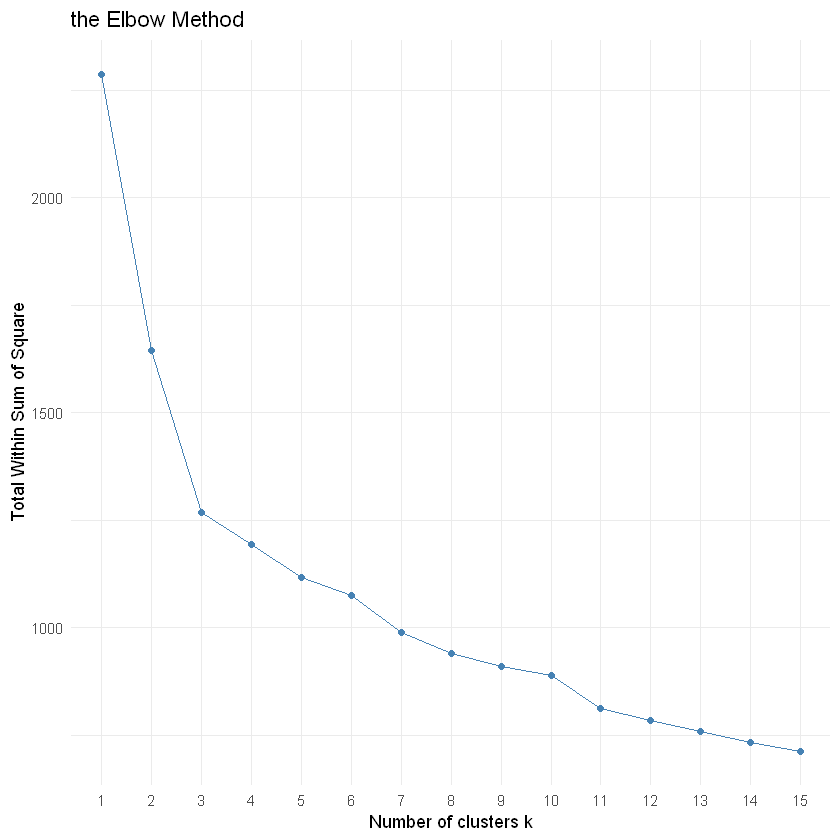

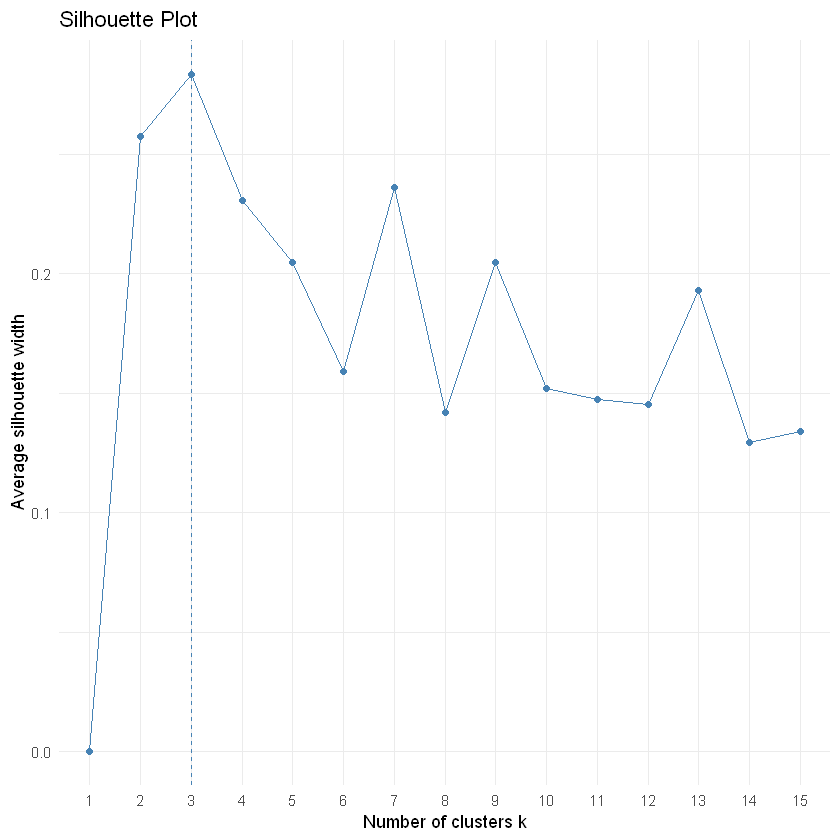

In [10]:
library(factoextra)
set.seed(1234) # 난수 고정을 안 해주면 결과가 달라질 수 있음
fviz_nbclust(df.train.scale, kmeans, method = "wss", k.max = 15) + # within sum of square, 군집 개수가 15개까지 나오게
    theme_minimal() + 
    ggtitle("the Elbow Method")

fviz_nbclust(df.train.scale, kmeans, method = "silhouette", k.max = 15) +
    theme_minimal() + 
    ggtitle("Silhouette Plot")

* 군집화

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Proanthocyanins.1,Hue,OD280/OD315 of diluted wines,Proline
1,0.8333649,-0.3013131,0.3661731,-0.6065538,0.56922228,0.88768039,0.98016451,-0.56173008,0.57583669,0.1702296,0.4753467,0.7753334,1.1296451
2,0.1736447,0.8642504,0.1871775,0.5168437,-0.06497127,-0.97106500,-1.20624204,0.71915195,-0.77171004,0.9378162,-1.1566204,-1.2872265,-0.4002655
3,-0.9183253,-0.3953334,-0.4905017,0.1637039,-0.48321576,-0.07114136,0.02658937,-0.03709561,0.06509498,-0.8955790,0.4614076,0.2823571,-0.7460740


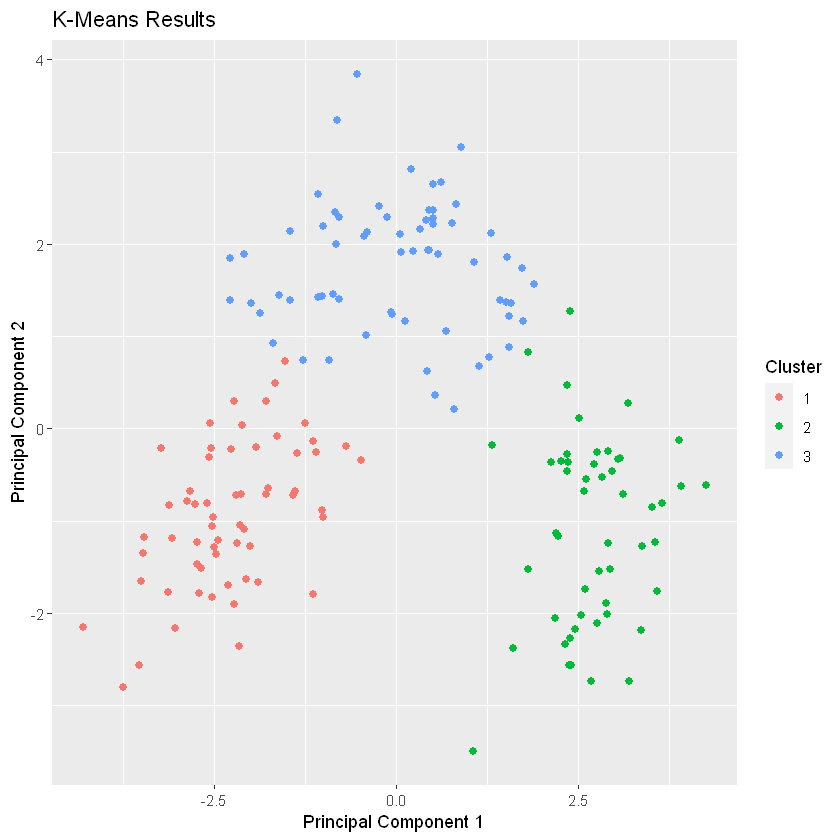

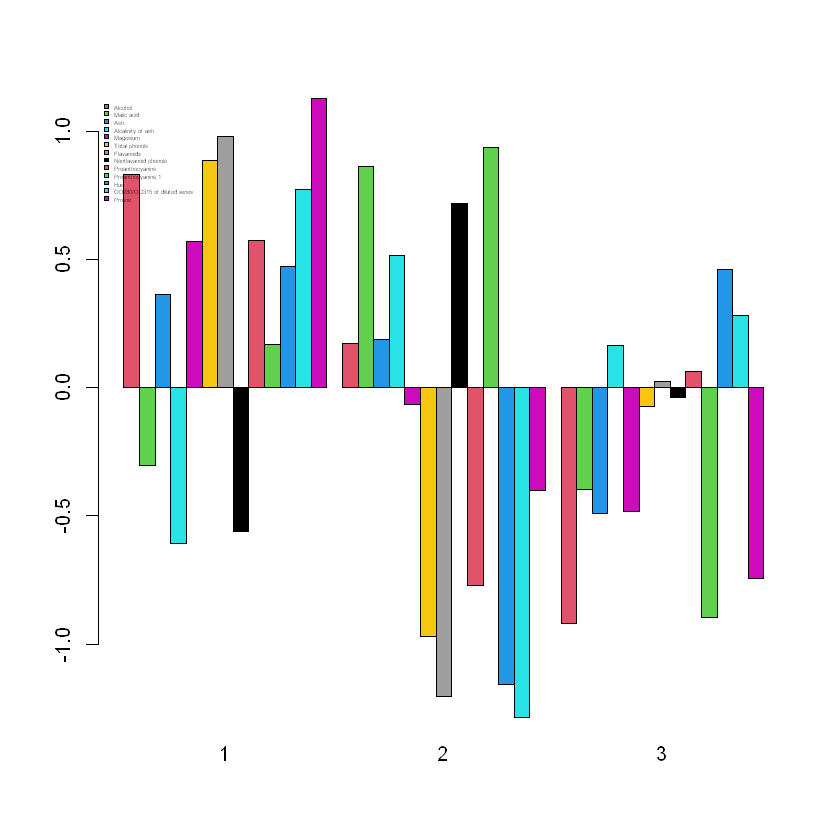

In [11]:
df.kmeans <- kmeans(df.train.scale, centers = 3, iter.max = 1000)

library(useful)
plot(df.kmeans, df.train.scale) # 2차원 그래프로 군집별 데이터 확인

# 군집별 평균 시각화
df.kmeans$centers # 각 군집별 평균값 확인
barplot(t(df.kmeans$centers), beside = T, col = 2:14)
legend("topleft", colnames(df.train.scale), fill = 2:14, cex = 0.3, bty = 'n')

In [12]:
# raw data에 cluster 할당
df$kmeans_cluster <- df.kmeans$cluster
head(df, 3)

,Cultivar,Alcohol,Malic acid,Ash,Alcalinity of ash,Magesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Proanthocyanins,Hue,OD280/OD315 of diluted wines,Proline,kmeans_cluster
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1


#### K medoids
* 군집 개수 설정

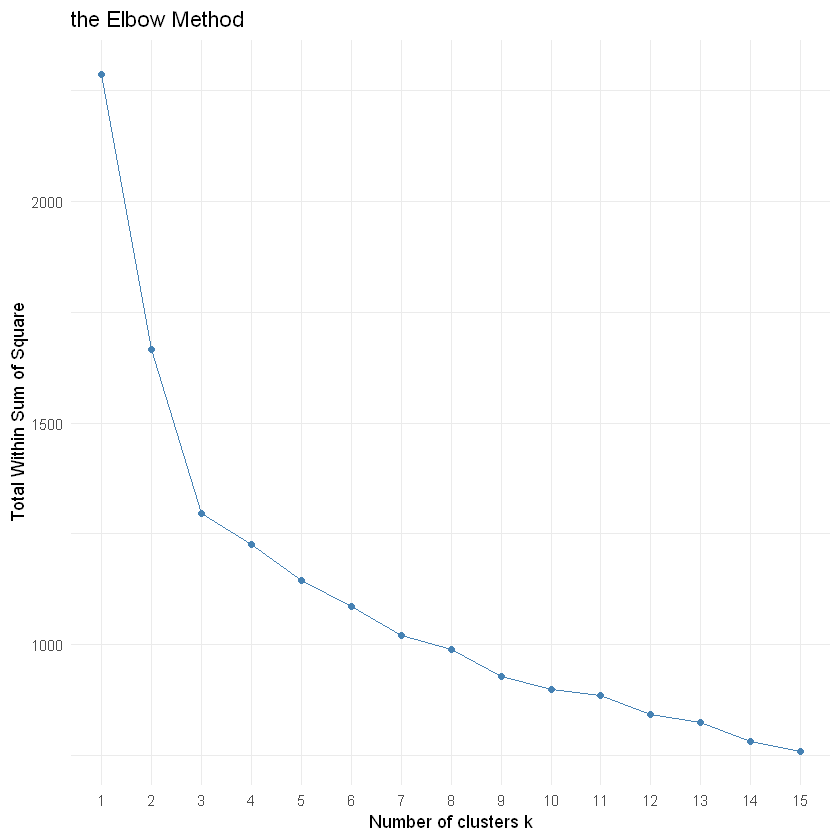

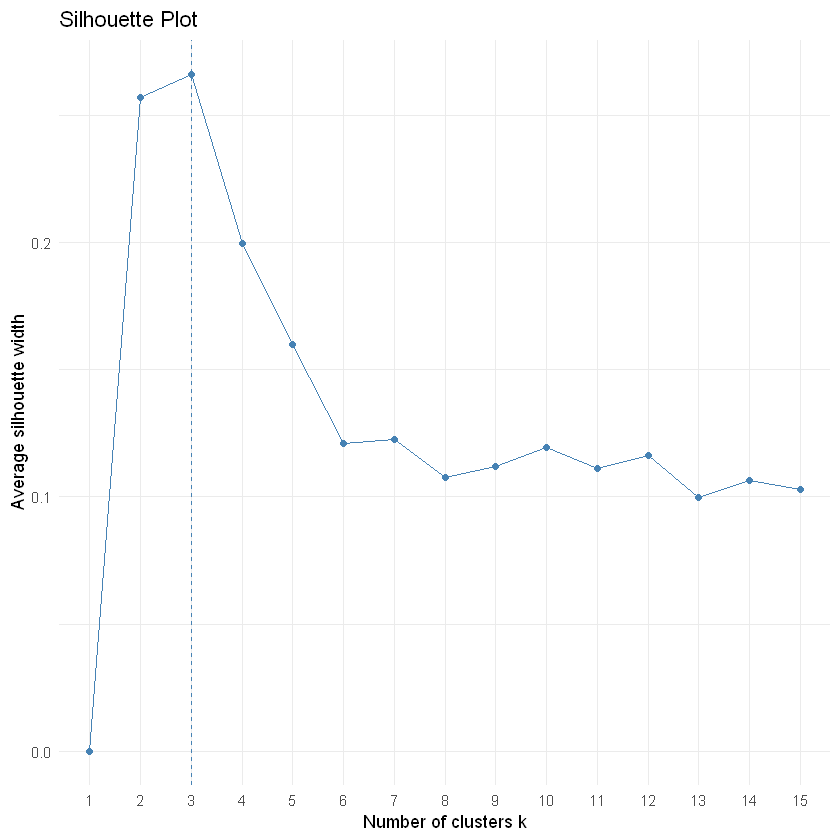

In [13]:
# k medoids clustering
library(factoextra)
library(cluster)
set.seed(1234)
fviz_nbclust(df.train.scale, pam, method = "wss", k.max = 15) +
    theme_minimal() +
    ggtitle("the Elbow Method")
fviz_nbclust(df.train.scale, pam, method = "silhouette", k.max = 15) +
    theme_minimal() +
    ggtitle("Silhouette Plot")

* 군집화

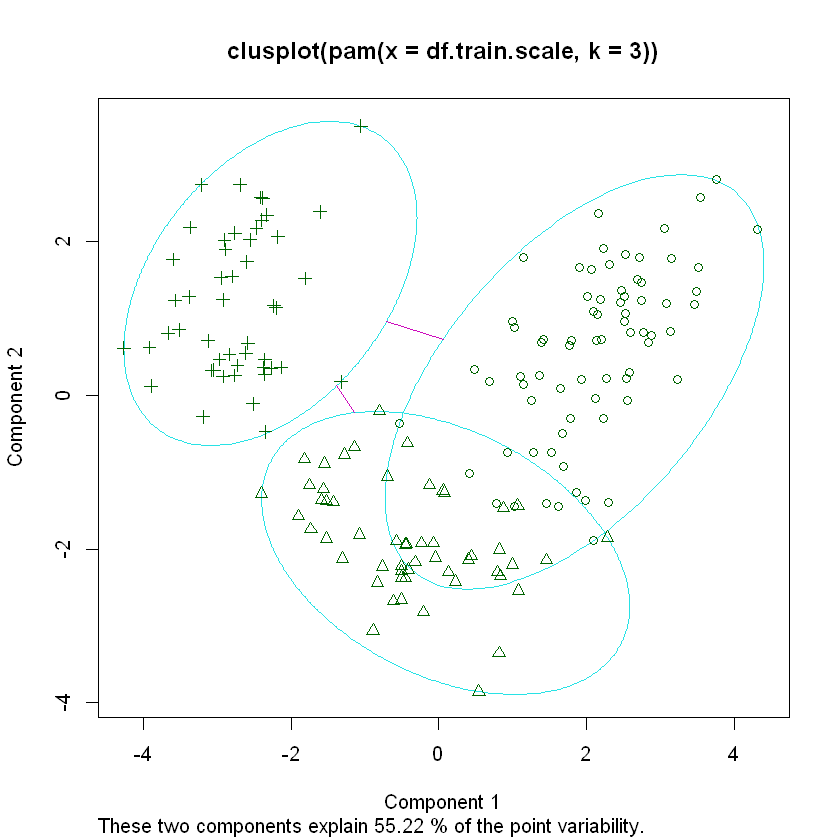

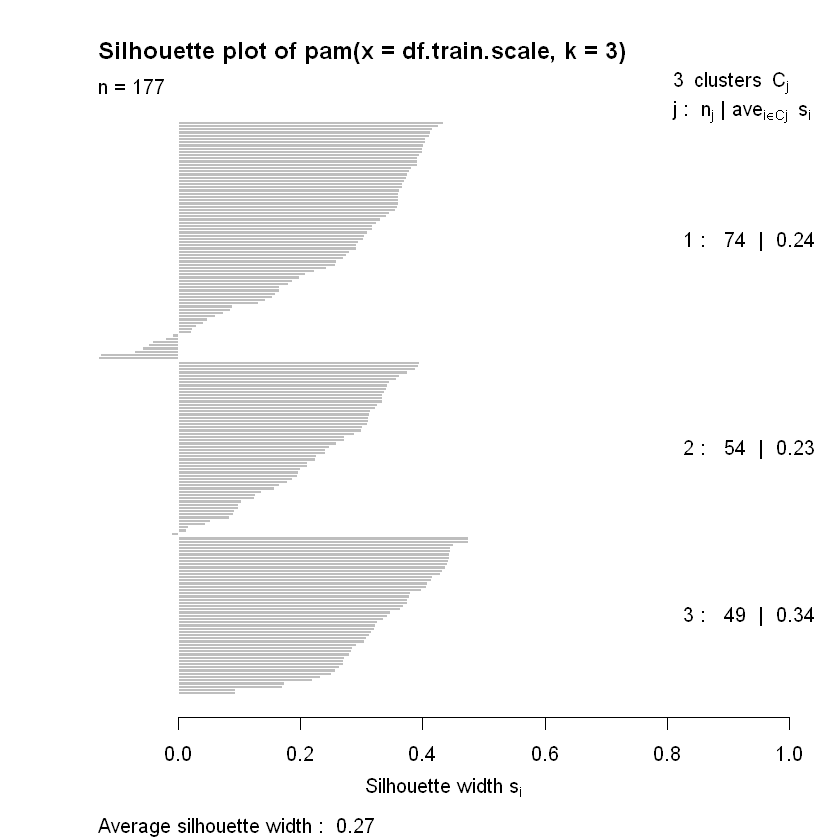

In [14]:
library(cluster)
df.kmedoids <- pam(df.train.scale, k = 3)
plot(df.kmedoids)

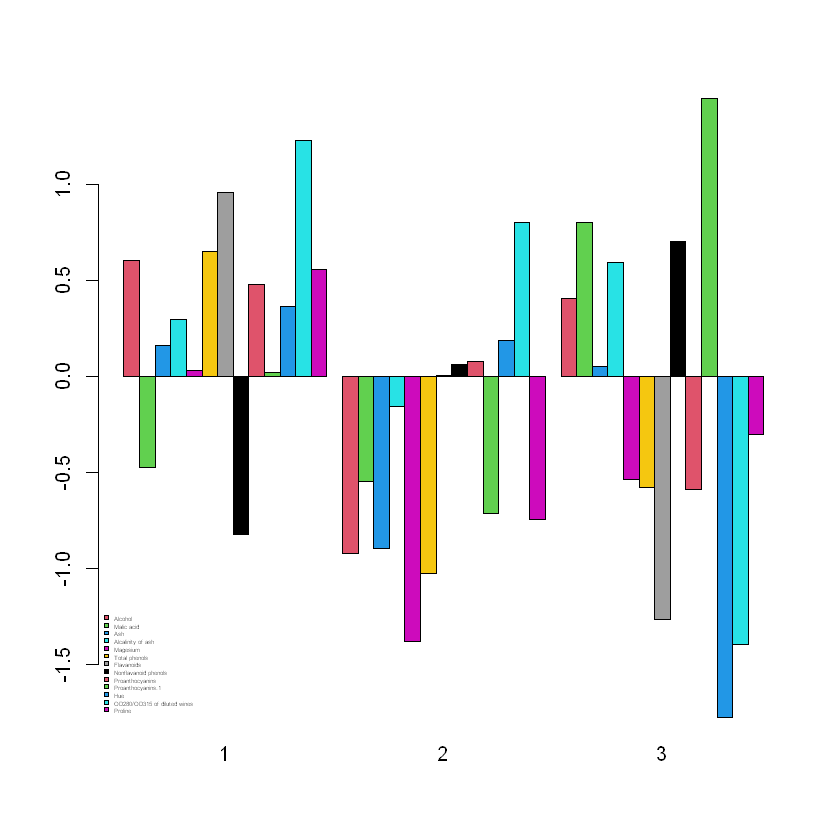

In [15]:
# 군집별 중앙점 시각화
barplot(t(df.kmedoids$medoids), beside = T, col = 2:14, names.arg = c(1:3))
legend("bottomleft", colnames(df.train.scale), fill = 2:14, cex = 0.3, bty = "n")

In [16]:
# raw data에 cluster 할당
df$kmedoids_cluster <- df.kmedoids$clustering
head(df, 3)

,Cultivar,Alcohol,Malic acid,Ash,Alcalinity of ash,Magesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Proanthocyanins,Hue,OD280/OD315 of diluted wines,Proline,kmeans_cluster,kmedoids_cluster
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,1


#### Hierarchical Clustering
* 군집 개수 설정

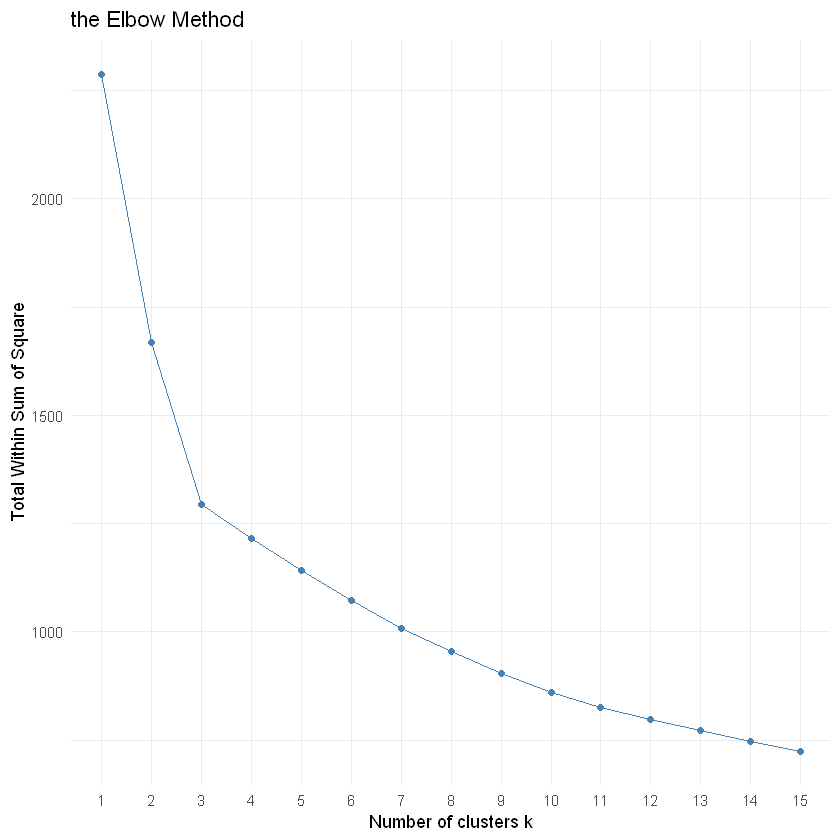

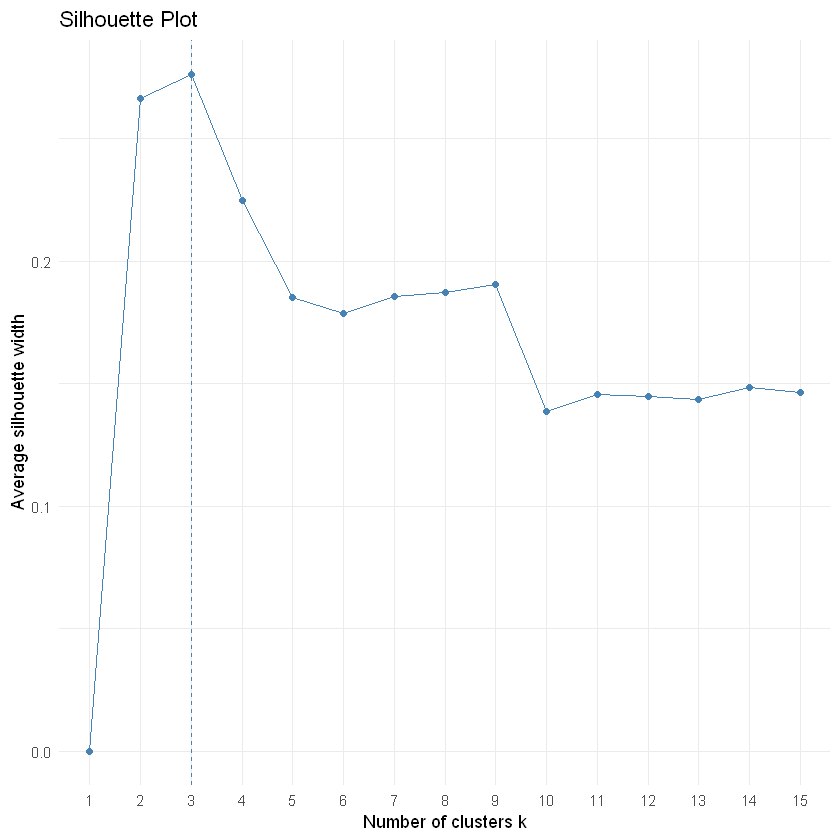

In [17]:
library(factoextra)
fviz_nbclust(df.train.scale, hcut, method = "wss", k.max = 15) +
    theme_minimal() +
    ggtitle("the Elbow Method")
fviz_nbclust(df.train.scale, hcut, method = "silhouette", k.max = 15) +
    theme_minimal() +
    ggtitle("Silhouette Plot")

* 군집 구성 방식 선택

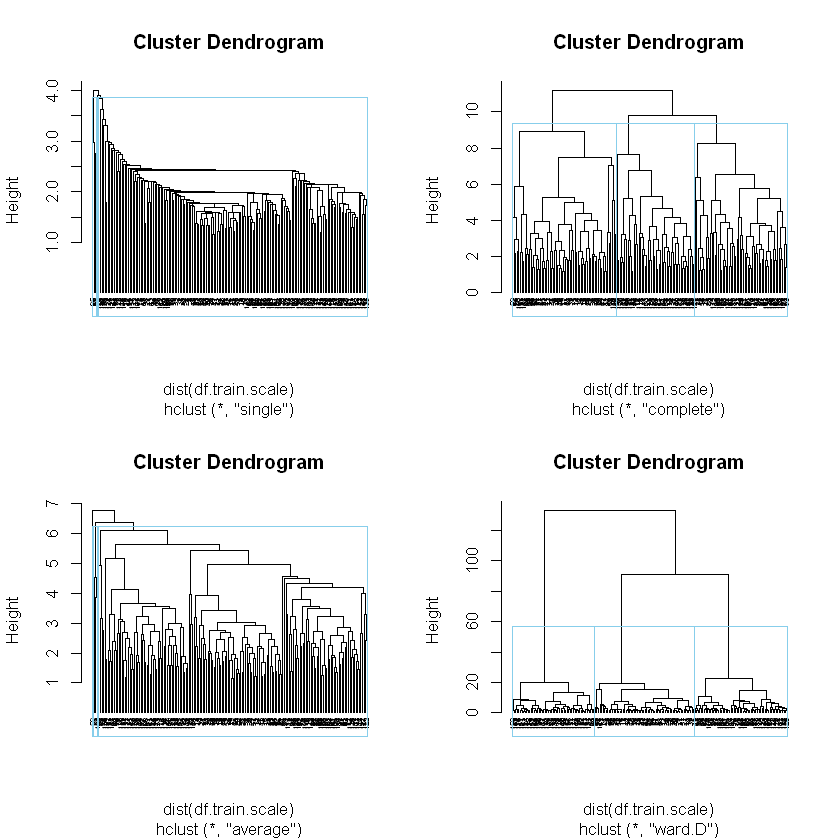

In [18]:
# 군집 구성 방식별 군집화 진행
df.hclust.single <- hclust(dist(df.train.scale), method = 'single')
df.hclust.cplt <- hclust(dist(df.train.scale), method = 'complete')
df.hclust.avg <- hclust(dist(df.train.scale), method = 'average')
df.hclust.ward <- hclust(dist(df.train.scale), method = 'ward.D')

#시각화 -> 군집 구성 방식 선택
par(mfrow = (c(2,2)))
plot(df.hclust.single, hang = -1, cex = 0.4) # hang : 덴드로그램이 가장 밑부터 모든 데이터가 출력되게
rect.hclust(df.hclust.single, k = 3, border = 'skyblue')
plot(df.hclust.cplt, hang = -1, cex = 0.4) # cex : 글자 크기
rect.hclust(df.hclust.cplt, k = 3, border = 'skyblue')
plot(df.hclust.avg, hang = -1, cex = 0.4)
rect.hclust(df.hclust.avg, k = 3, border = 'skyblue')
plot(df.hclust.ward, hang = -1, cex = 0.4)
rect.hclust(df.hclust.ward, k = 3, border = 'skyblue')

complete와 ward.D가 편향되지 않게 3개의 군집을 적절히 나눔   
-> ward.D가 전체 데이터를 고려해 거리를 계산하는 방식이라 더 적합하다 판단 -> 선택

* ward's Method로 군집화 및 군집 할당

In [19]:
hclust_cluster <- cutree(df.hclust.ward, k = 3)
df$hclust_cluster <- hclust_cluster

head(df, 3)

,Cultivar,Alcohol,Malic acid,Ash,Alcalinity of ash,Magesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Proanthocyanins,Hue,OD280/OD315 of diluted wines,Proline,kmeans_cluster,kmedoids_cluster,hclust_cluster
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1,1,1
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1,1,1
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1,1,1


kmeans가 kmedoids보다 잘 나누어지는 경향이 있음 -> kmeans와 hclust 중 아무 거나 선택해도 됨

* 1번 와인을 구매한 고객에게 와인 추천
    * 1번 와인과 다른 군집 중 추천할 군집 선택
    * 해당 군집 중 추천할 와인 선택

---
## 정리
* 현업에서의 프로세스


1. 아이디어 도출 및 구체화
2. 데이터분석가 작업
    1. 데이터 추출
    2. 데이터 전처리 및 모델링
    3. 결과 추출
    4. 추천용 데이터셋 구성(DB 업로드)
    5. 추천 로직 정리 <br><br>
    
    
* 와인 추천을 위한 데이터셋(분석 결과물)


1. 유사도 행렬(df.dist)
    * 유사한 성격의 와인을 찾는 데 활용
2. 군집 데이터(df\$kmeans_cluster, df\$kmedoids_cluster, df\$hclust_cluster)
    * 다른 성격의 와인 그룹을 찾는 데 활용